<center>
    <h1> Bài Tập Lớn : Datamining</h1>
    <h2> Đề Tài : Phân loại cảm xúc <h2>
 </center>

---

In [1]:
# 1. Imports
import pandas as pd
import torch
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

c:\Users\haicx\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Cấu hình & Khởi tạo đường dẫn
INPUT_FILE  = r"Data.csv"
CACHE_DIR   = r"D:\BTLdatamining\cached_models" # Nơi lưu model đã tải
OUTPUT_FILE = r"Data_Sentiment_Analysis_Result.csv"

In [3]:
# 3. Kiểm tra môi trường
os.makedirs(CACHE_DIR, exist_ok=True)
if not os.path.exists(INPUT_FILE):
    print(f"[LỖI] Không tìm thấy file: {INPUT_FILE}. Vui lòng kiểm tra lại đường dẫn!")
else:
    print(f" Tìm thấy file: {INPUT_FILE}")
    print("Các thư viện đã được import và thư mục cache đã sẵn sàng.")

 Tìm thấy file: Data.csv
Các thư viện đã được import và thư mục cache đã sẵn sàng.


In [4]:
# 4. CHUẨN BỊ VÀ TẢI MODEL
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

print(f"Đang tải model: {model_name}")

# Tải Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir=CACHE_DIR)

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Đặt mô hình ở chế độ đánh giá

print(f" Model đã sẵn sàng trên: {str(device).upper()}")

Đang tải model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Model đã sẵn sàng trên: CPU


In [5]:
# 5. ĐỊNH NGHĨA HÀM LÀM SẠCH VĂN BẢN (Text Preprocessing)
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Chỉ giữ chữ cái tiếng Anh và khoảng trắng (Phù hợp với mô hình RoBERTa)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Xóa khoảng trắng thừa và chuyển thành chữ thường
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

print(" Hàm clean_text đã được định nghĩa.")

 Hàm clean_text đã được định nghĩa.


In [6]:
# 6. ĐỊNH NGHĨA HÀM DỰ ĐOÁN CẢM XÚC
def predict_sentiment(text):
    # 1. Làm sạch văn bản
    text = clean_text(text)
    if len(text) < 3:
        # Xử lý các dòng quá ngắn hoặc bị làm sạch hết
        return "Trung lập", 0, 1.0 # Gán Trung lập và độ tin cậy tuyệt đối

    # 2. Tokenize và chuẩn bị input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Chạy Model
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confidence, pred = torch.max(probs, dim=1)

    # 4. Ánh xạ kết quả (0=Negative, 1=Neutral, 2=Positive)
    mapping = {0: ("Tiêu cực", -1), 1: ("Trung lập", 0), 2: ("Tích cực", 1)}
    sentiment_text, label = mapping[pred.item()]
    return sentiment_text, label, round(confidence.item(), 4)

print(" Hàm predict_sentiment đã sẵn sàng.")

 Hàm predict_sentiment đã sẵn sàng.


In [7]:
# 7. ĐỌC DỮ LIỆU VÀ KHÁM PHÁ CẤU TRÚC (EDA)
print("Đang đọc Data...")
try:
    df = pd.read_csv(INPUT_FILE, on_bad_lines='skip')
    print(f"Đã đọc thành công {len(df):,} dòng dữ liệu.")

    print("\n--- Thông tin Dataframe ---")
    df.info()

    # Kiểm tra cột 'Text' và loại bỏ Missing Values
    if 'Text' in df.columns:
        df.dropna(subset=['Text'], inplace=True)
        print(f"\nSố dòng sau khi làm sạch Missing Value: {len(df):,}")
    
    else:
        print("\n[LỖI] Không tìm thấy cột 'Text'. Vui lòng kiểm tra lại cấu trúc file CSV.")

except Exception as e:
    print(f"[LỖI] Không thể đọc file CSV: {e}")

Đang đọc Data...
Đã đọc thành công 732 dòng dữ liệu.

--- Thông tin Dataframe ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Timestamp     732 non-null    object 
 4   User          732 non-null    object 
 5   Platform      732 non-null    object 
 6   Hashtags      732 non-null    object 
 7   Retweets      732 non-null    float64
 8   Likes         732 non-null    float64
 9   Country       732 non-null    object 
 10  Year          732 non-null    int64  
 11  Month         732 non-null    int64  
 12  Day           732 non-null    int64  
 13  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 80.2+ KB

Số dòng sau khi làm sạch Missing Value: 732


In [8]:
# đọc thử 1 dòng trong data
print(df.loc[[300],['Text']].values)

[[' Eyes wide open in the night, fearful shadows dancing on the walls, the mind a prisoner of imagined horrors. ']]


In [9]:
## 7. Các dòng dữ liệu missing
print("Các dữ liệu missing")

df.isnull().sum()


Các dữ liệu missing


Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64

In [10]:
#Kiểm tra dữ liệu trùng lặp:
df.duplicated().sum()

np.int64(0)

In [11]:
#  PHÂN TÍCH TÓM TẮT CHẤT LƯỢNG DỮ LIỆU (DATA SUMMARY TABLE)
print("--- Bảng Tóm Tắt Chất Lượng Dữ Liệu ---")

if 'df' in locals() and not df.empty:
    summary_data = []
    for col in df.columns:
        summary_data.append({
            'Tên Cột': col,
            'Kiểu Dữ Liệu (Dtype)': df[col].dtype,
            'Số Lượng Giá Trị Duy Nhất': df[col].nunique(),
            'Phần Trăm Giá Trị Thiếu': round(df[col].isnull().sum() / len(df) * 100, 2)
        })

    df_summary = pd.DataFrame(summary_data)
    print("Thông tin cột:")
    print(df_summary.to_string(index=False))

    # Thêm phân tích độ dài văn bản cho cột 'Text'
    if 'Text' in df.columns:
        df['Text_Length'] = df['Text'].astype(str).apply(len)
        print("\n--- Thống Kê Độ Dài Văn Bản trong cột 'Text' ---")
        print(df['Text_Length'].describe().to_string())
        df.drop(columns=['Text_Length'], inplace=True, errors='ignore') # Xóa cột tạm thời
else:
    print("[LỖI] Không tìm thấy DataFrame 'df' để tạo bảng phân tích.")

--- Bảng Tóm Tắt Chất Lượng Dữ Liệu ---
Thông tin cột:
     Tên Cột Kiểu Dữ Liệu (Dtype)  Số Lượng Giá Trị Duy Nhất  Phần Trăm Giá Trị Thiếu
Unnamed: 0.1                int64                        732                      0.0
  Unnamed: 0                int64                        732                      0.0
        Text               object                        707                      0.0
   Timestamp               object                        683                      0.0
        User               object                        685                      0.0
    Platform               object                          4                      0.0
    Hashtags               object                        697                      0.0
    Retweets              float64                         26                      0.0
       Likes              float64                         38                      0.0
     Country               object                        115                      0.0

In [12]:
# 8. THỬ NGHIỆM LÀM SẠCH VĂN BẢN
print("--- 2 Dòng Dữ Liệu Trước và Sau Khi Làm Sạch ---")
    
# Lấy 2 dòng đầu tiên
df_compare = df[['Text']].head(2).copy()
    
# Áp dụng hàm clean_text đã định nghĩa
df_compare['Text_Cleaned'] = df_compare['Text'].astype(str).apply(clean_text)
    
# Đổi tên cột Text thành Text_Original để dễ so sánh
df_compare.rename(columns={'Text': 'Text_Original', 'Text_Cleaned': 'Text_Sau_Lam_Sach'}, inplace=True)
    
# Hiển thị kết quả
pd.set_option('display.max_colwidth', None) # Hiển thị toàn bộ nội dung cột
print(df_compare.to_string(index=False))


--- 2 Dòng Dữ Liệu Trước và Sau Khi Làm Sạch ---
                                       Text_Original                    Text_Sau_Lam_Sach
 Enjoying a beautiful day at the park!               enjoying a beautiful day at the park
 Traffic was terrible this morning.                     traffic was terrible this morning


In [13]:
# 9. THỬ NGHIỆM HÀM DỰ ĐOÁN

print("--- THỬ NGHIỆM VỚI CÁC  MẪU ---")
df_sample = df.sample(n=3, random_state=42) 
    
for index, row in df_sample.iterrows():
    phrase = row['Text']
    sentiment, label, confidence = predict_sentiment(phrase)
        
    print(f"\n[Dòng Index: {index}]")
    print(f"Văn bản gốc: '{phrase}'")
    print(f"Dự đoán: Cảm xúc: {sentiment} (Độ tin cậy: {confidence})")

--- THỬ NGHIỆM VỚI CÁC  MẪU ---

[Dòng Index: 604]
Văn bản gốc: 'Exploring the world of digital art. It's never too late to discover new passions. #DigitalArtistry #LateBloomer '
Dự đoán: Cảm xúc: Tích cực (Độ tin cậy: 0.8059)

[Dòng Index: 33]
Văn bản gốc: ' Feeling inspired after attending a workshop.       '
Dự đoán: Cảm xúc: Tích cực (Độ tin cậy: 0.9464)

[Dòng Index: 300]
Văn bản gốc: ' Eyes wide open in the night, fearful shadows dancing on the walls, the mind a prisoner of imagined horrors. '
Dự đoán: Cảm xúc: Trung lập (Độ tin cậy: 0.5475)


In [14]:
# 10. CHẠY DỰ ĐOÁN HÀNG LOẠT (Tạo cột 'Cảm_xúc', 'Label', 'Độ_tin_cậy')
if 'df' in locals() and 'Text' in df.columns and not df.empty:
    print("\nBắt đầu dự đoán cảm xúc cho toàn bộ dữ liệu...")
    tqdm.pandas()

    # Áp dụng hàm predict_sentiment và tách kết quả thành 3 cột mới
    results = df['Text'].progress_apply(predict_sentiment)
    df[['Cảm_xúc', 'Label', 'Độ_tin_cậy']] = pd.DataFrame(results.tolist(), index=df.index)

    print(" HOÀN TẤT DỰ ĐOÁN!")
    print("\n--- 5 Dòng đầu tiên đã có kết quả dự đoán ---")
    print(df[['Text', 'Cảm_xúc', 'Độ_tin_cậy']].head())
else:
    # Nếu dòng này in ra, bạn cần quay lại Cell 5 để kiểm tra việc đọc file CSV.
    print("\n[LỖI] Không thể chạy dự đoán do thiếu DataFrame hoặc cột 'Text'.")


Bắt đầu dự đoán cảm xúc cho toàn bộ dữ liệu...


100%|██████████| 732/732 [00:15<00:00, 47.82it/s]

 HOÀN TẤT DỰ ĐOÁN!

--- 5 Dòng đầu tiên đã có kết quả dự đoán ---
                                                   Text    Cảm_xúc  Độ_tin_cậy
0   Enjoying a beautiful day at the park!                 Tích cực      0.9846
1   Traffic was terrible this morning.                    Tiêu cực      0.9430
2    Just finished an amazing workout! 💪                  Tích cực      0.9785
3   Excited about the upcoming weekend getaway!           Tích cực      0.9820
4   Trying out a new recipe for dinner tonight.          Trung lập      0.7468


In [15]:
# 11. PHÂN TÍCH CÁC DÒNG CÓ ĐỘ TIN CẬY THẤP (Low Confidence Analysis)
MIN_CONFIDENCE = 0.65

print(f"PHÂN TÍCH DỮ LIỆU CÓ ĐỘ TIN CẬY THẤP (Dưới {MIN_CONFIDENCE*100:.0f}%)")

df_low_conf = df[df['Độ_tin_cậy'] < MIN_CONFIDENCE].sort_values(by='Độ_tin_cậy', ascending=True)

if not df_low_conf.empty:
    print(f" Tìm thấy {len(df_low_conf):,} dòng có độ tin cậy thấp. (Nên kiểm tra lại)")
    print("--- 10 Dòng có độ tin cậy thấp nhất ---")
    print(df_low_conf[['Text', 'Cảm_xúc', 'Độ_tin_cậy']].head(10).to_string(index=False))
else:
    print(" Rất tốt! Không có dòng nào có độ tin cậy dưới 65%.")

PHÂN TÍCH DỮ LIỆU CÓ ĐỘ TIN CẬY THẤP (Dưới 65%)
 Tìm thấy 188 dòng có độ tin cậy thấp. (Nên kiểm tra lại)
--- 10 Dòng có độ tin cậy thấp nhất ---
                                                                                                                                          Text   Cảm_xúc  Độ_tin_cậy
           Spent an hour choosing the perfect filter for a selfie. The struggle for that Instagram aesthetic is real. #SelfieQueen #TeenVibes   Tiêu cực      0.4267
                                                                              Overwhelmed by the support received during a personal challenge. Trung lập      0.4364
                                                         Embracing imperfections, finding acceptance in the mosaic of life's beautiful chaos.   Tích cực      0.4828
                                      Attempting to set a new record for the most consecutive hacky sack kicks. Hacky sack skills: Unleashed!  Trung lập      0.4836
                             

BÁO CÁO KẾT QUẢ PHÂN TÍCH CẢM XÚC
  Cảm xúc  Số lượng  Tỷ lệ (%)
 Tích cực       396      54.10
Trung lập       173      23.63
 Tiêu cực       163      22.27


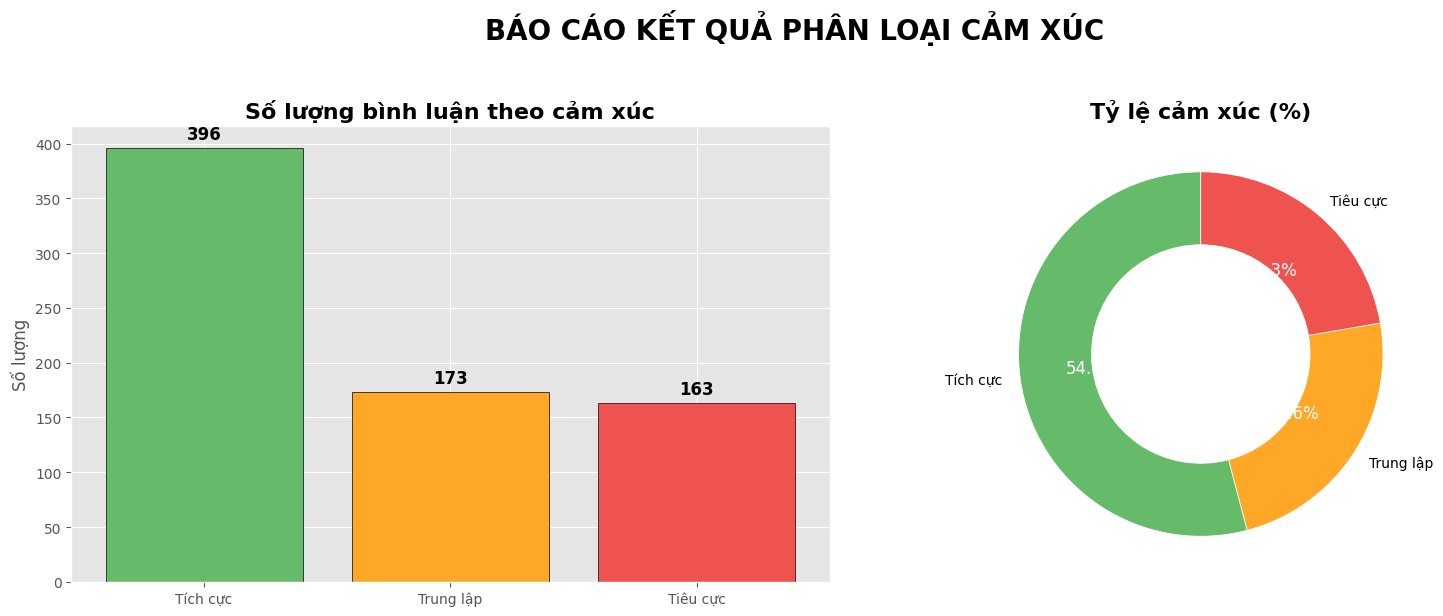

In [16]:
# 12. TỔNG HỢP VÀ TRỰC QUAN HÓA KẾT QUẢ 📊
print("="*60)
print("BÁO CÁO KẾT QUẢ PHÂN TÍCH CẢM XÚC")
print("="*60)

# 1. Tổng hợp dữ liệu
summary = df['Cảm_xúc'].value_counts().reset_index()
summary.columns = ['Cảm xúc', 'Số lượng']
total = len(df)
summary['Tỷ lệ (%)'] = (summary['Số lượng'] / total * 100).round(2)

# Sắp xếp theo thứ tự logic: Tích cực, Trung lập, Tiêu cực
mapping_order = {"Tích cực": 1, "Trung lập": 0, "Tiêu cực": -1}
summary['Order'] = summary['Cảm xúc'].map(mapping_order)
summary = summary.sort_values(by='Order', ascending=False).drop(columns=['Order'])

print(summary.to_string(index=False))

# 2. Trực quan hóa (Visualization)
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Màu sắc: Xanh (Tích cực) - Cam (Trung lập) - Đỏ (Tiêu cực)
colors = ['#66bb6a', '#ffa726', '#ef5350']
color_map = {k: c for k, c in zip(summary['Cảm xúc'], colors)}
sorted_colors = [color_map[c] for c in summary['Cảm xúc']]

# Biểu đồ cột
bars = ax1.bar(summary['Cảm xúc'], summary['Số lượng'], color=sorted_colors, edgecolor='black')
ax1.set_title('Số lượng bình luận theo cảm xúc', fontsize=16, fontweight='bold')
ax1.set_ylabel('Số lượng', fontsize=12)

# Ghi số lên đầu cột
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Biểu đồ tròn
wedges, texts, autotexts = ax2.pie(summary['Số lượng'], labels=summary['Cảm xúc'],
                                   autopct='%1.1f%%', colors=sorted_colors, startangle=90,
                                   wedgeprops=dict(width=0.4, edgecolor='white'))
ax2.set_title('Tỷ lệ cảm xúc (%)', fontsize=16, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

plt.suptitle('BÁO CÁO KẾT QUẢ PHÂN LOẠI CẢM XÚC', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [17]:
# 13. LƯU KẾT QUẢ VÀO FILE CSV
print("Đang lưu kết quả vào file CSV...")

if 'df' in locals() and not df.empty:
    # CHỈ LƯU CÁC CỘT: Text, Cảm_xúc, và Độ_tin_cậy (Đã bỏ cột 'Label')
    df_output = df[['Text', 'Cảm_xúc', 'Độ_tin_cậy']]
    
    df_output.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')
    print(f" Lưu thành công {len(df):,} dòng vào file: {OUTPUT_FILE}")
else:
    print("[LỖI] Không tìm thấy DataFrame để lưu!")

Đang lưu kết quả vào file CSV...
 Lưu thành công 732 dòng vào file: Data_Sentiment_Analysis_Result.csv


## Một số phần làm thêm

Đã làm sạch khoảng trắng ở cột 'Platform'.

Các nền tảng duy nhất sau khi làm sạch:
['Twitter' 'Instagram' 'Facebook']

Đã tạo cột 'SentimentScore' (số) từ cột 'Cảm_xúc' (chữ).

Bảng đếm số lượng cảm xúc theo Platform:
           Negative  Neutral  Positive
Platform                              
Facebook         53       55       123
Instagram        51       59       148
Twitter          59       59       125


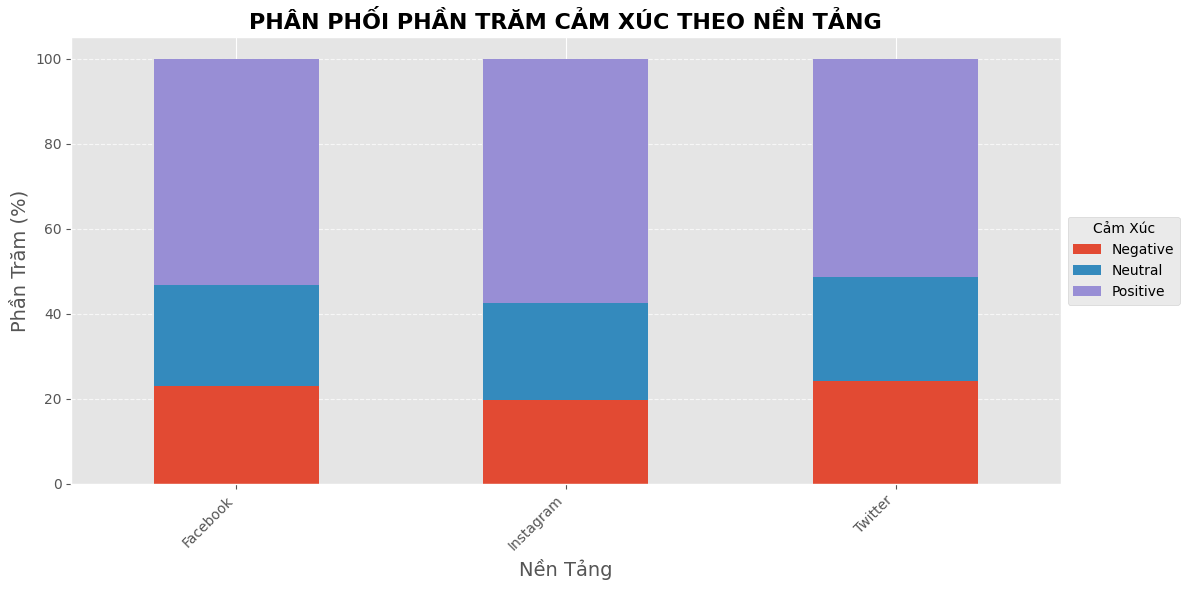

In [18]:
# 12. LÀM SẠCH CỘT 'Platform' VÀ KIỂM TRA
df['Platform'] = df['Platform'].str.strip()
print("Đã làm sạch khoảng trắng ở cột 'Platform'.")

# Lấy các giá trị duy nhất từ ​​cột "Platform" đã được dọn sạch
unique_platforms = df['Platform'].unique()
print(f"\nCác nền tảng duy nhất sau khi làm sạch:\n{unique_platforms}")

# --- BƯỚC CẦN THIẾT: Ánh xạ 'Cảm_xúc' (từ Cell 10) sang 'SentimentScore' (số) ---
def map_sentiment_to_score(sentiment):
    if sentiment == 'Tích cực':
        return 1
    elif sentiment == 'Tiêu cực':
        return -1
    else: # Trung tính
        return 0

df['SentimentScore'] = df['Cảm_xúc'].apply(map_sentiment_to_score)
print("\nĐã tạo cột 'SentimentScore' (số) từ cột 'Cảm_xúc' (chữ).")


# 12. PHÂN BỐ CẢM XÚC THEO NỀN TẢNG (Sử dụng code gốc của bạn)

# Nhóm theo nền tảng và tình cảm, sau đó đếm số lần xuất hiện
sentiment_counts = df.groupby(['Platform', 'SentimentScore']).size().unstack(fill_value=0)

# Đảm bảo cả ba loại cảm xúc (-1, 0, 1) đều có mặt
for sentiment in [-1, 0, 1]:
    if sentiment not in sentiment_counts.columns:
        sentiment_counts[sentiment] = 0

# Sắp xếp lại các cột để duy trì tính nhất quán
sentiment_counts = sentiment_counts[[-1, 0, 1]]

# Đổi tên cột để dễ đọc hơn
sentiment_counts.columns = ['Negative', 'Neutral', 'Positive']
print(f"\nBảng đếm số lượng cảm xúc theo Platform:\n{sentiment_counts}")

# Tính toán phần trăm tình cảm
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Vẽ biểu đồ phần trăm cảm xúc
plt.figure(figsize=(12, 6))
sentiment_percentages.plot(kind='bar', stacked=True, ax=plt.gca())

plt.title('PHÂN PHỐI PHẦN TRĂM CẢM XÚC THEO NỀN TẢNG', fontsize=16, fontweight='bold')
plt.xlabel('Nền Tảng', fontsize=14)
plt.ylabel('Phần Trăm (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cảm Xúc', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
df['Cleaned_Text'] = df['Text'].apply(clean_text)

first_clean_text = df['Cleaned_Text'].iloc[0]

inputs = tokenizer(first_clean_text, return_tensors='pt')

with torch.no_grad():
    # Gọi mô hình. 'outputs' chứa Logits
    outputs = model(**inputs) 
    
    # Lấy vector Logits (đầu ra thô)
    logits = outputs.logits

print("--- KẾT QUẢ LOGITS TỪ MÔ HÌNH ---")
print(f"Câu văn: '{first_clean_text}'")
print(f"Vector Logits (Tiêu cực, Trung lập, Tích cực):\n{logits}")

# --- (Phần bổ sung: Tính Softmax cho Xác suất) ---
softmax_output = torch.softmax(logits, dim=1).tolist()[0]
labels = ["Tiêu cực (-1)", "Trung lập (0)", "Tích cực (1)"]

print("\n--- XÁC SUẤT SAU SOFTMAX ---")
for label, prob in zip(labels, softmax_output):
    print(f"{label}: {prob:.4f}")


sentiment_value_mapping = [-1, 0, 1] 

predicted_label_index = torch.argmax(logits, dim=1).item() 


labels_name = ["Tiêu cực", "Trung lập", "Tích cực"]
predicted_label_name = labels_name[predicted_label_index]

predicted_sentiment_value = sentiment_value_mapping[predicted_label_index]


confidence_score = softmax_output[predicted_label_index]

print("\n--- SỰ LỰA CHỌN CỦA MÔ HÌNH ---")
print(f"Nhãn Dự đoán (Index): {predicted_label_index}")
print(f"Sự Lựa chọn: **{predicted_label_name}**")
print(f"Giá trị Cảm xúc (-1, 0, 1):   {predicted_sentiment_value}") # IN KẾT QUẢ MỚI
print(f"Độ tin cậy: {confidence_score:.4f} ({confidence_score * 100:.2f}%)")

--- KẾT QUẢ LOGITS TỪ MÔ HÌNH ---
Câu văn: 'enjoying a beautiful day at the park'
Vector Logits (Tiêu cực, Trung lập, Tích cực):
tensor([[-2.3653, -1.0330,  3.3607]])

--- XÁC SUẤT SAU SOFTMAX ---
Tiêu cực (-1): 0.0032
Trung lập (0): 0.0122
Tích cực (1): 0.9846

--- SỰ LỰA CHỌN CỦA MÔ HÌNH ---
Nhãn Dự đoán (Index): 2
Sự Lựa chọn: **Tích cực**
Giá trị Cảm xúc (-1, 0, 1):   1
Độ tin cậy: 0.9846 (98.46%)
